## CIFAR-10 이미지 생성하기


### - 라이브러리 및 데이터셋 불러오기

In [58]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [59]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [60]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [61]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


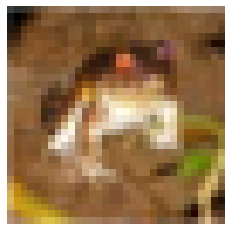

In [62]:
# 정규화된 이미지 확인 (예시로 첫 번째 이미지 시각화)
plt.figure()
plt.imshow((train_x[0] + 1.0) / 2.0)  # 정규화를 해제하여 이미지 표시
plt.axis('off')
plt.show()

In [63]:
# tf.data.Dataset 구성
batch_size = 256
BUFFER_SIZE = 50000

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(batch_size)

In [65]:
# 미니배치 데이터 확인 (예시로 첫 번째 미니배치)
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)

Batch shape: (256, 32, 32, 3)


In [66]:
# airplane 데이터만 로드하여 학습 진행
def load_data(label='Airplane'):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

## STEP 3. 생성자 모델 구현하기

In [83]:
# 생성자 모델 구현
def build_generator(input_shape=(100,)):
    model = tf.keras.Sequential()

    # 입력 노이즈를 8*8x256 크기의 텐서로 변환 (Dense Layer)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 8*8*256에서 16*16*128 크기의 텐서로 업샘플링 (Reshape 및 Conv2DTranspose Layer)
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 16*16*128에서 32*32*64 크기의 텐서로 업샘플링 (Conv2DTranspose Layer)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 32*32*64에서 32*32*3 크기의 컬러 이미지 생성 (Conv2DTranspose Layer, 채널 수 3)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

# 생성자 모델 생성
generator = build_generator()

generator.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_43 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16, 16, 128)     

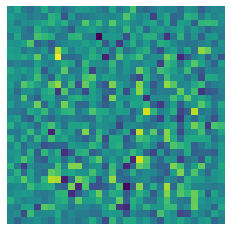

TensorShape([1, 32, 32, 3])

In [96]:
# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

# 랜덤 이미지 생성
generated_image = generator(noise, training=False)

# 생성된 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()
generated_image.shape

## STEP 4. 판별자 모델 구현하기

In [106]:
def build_discriminator(input_shape):
    model = tf.keras.Sequential()
    
    # 입력 이미지의 크기 (32x32x3)
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # 판별 결과 출력 (1 또는 0)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = build_discriminator((32, 32, 3))
discriminator.summary()


# 랜덤 이미지 판별 결과 확인
discriminator_output = discriminator(generated_image)
print(discriminator_output)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4096)            

In [107]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49982935]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

In [108]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [109]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [110]:
# 판별자의 손실함수 구현
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [111]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [112]:
# 최적화 함수 구현
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

In [113]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([batch_size, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)  # [[YOUR CODE]]: 생성자가 생성한 이미지에 대한 판별 결과

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)  # [[YOUR CODE]]: 판별자의 손실

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # [[YOUR CODE]]: 판별자의 gradient

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # [[YOUR CODE]]: 판별자 모델의 gradient 적용

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


In [120]:
# 이미지를 시각화하는 generate and save images 구현
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [121]:
# draw_train_history 구현
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [122]:
# checkpoint 모델 구현
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [123]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [124]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

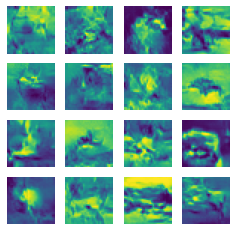

Epoch 24 | iter 101
Time for epoch 24 : 13 sec


KeyboardInterrupt: 

In [125]:
%%time
for epoch in range(EPOCHS):
    train(train_dataset, EPOCHS, save_every)

### 에폭을 50 *50 번을 돌리는건 너무 오래걸려 학습을 중단하고 도중 제출

In [126]:
# 학습과정 시각화
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 562333 Sep 21 04:13 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
